# **Inference for ZeroDCE model using trained models**


---

Colab Version

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/FYP/ZeoroDCE/Test_Code2'

/content/drive/MyDrive/FYP/ZeoroDCE/Test_Code2


In [ ]:
from IPython.display import clear_output
!pip install -q tensorflow==2.4.1


In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, callbacks


In [ ]:
# Experiment Configs

SEED = 10
random.seed(SEED)
tf.random.set_seed(SEED)


IMAGE_SIZE = 256
TEST_IMAGE_DIR = "/content/drive/MyDrive/FYP/ZeoroDCE/LOLdataset_All/eval15/low"


In [ ]:
test_image_files = glob(os.path.join(TEST_IMAGE_DIR, "*.png"))
print("Number of Test Images from LOL Dataset:", len(test_image_files))

Number of Test Images from LOL Dataset: 15


**Zero DCE**

In [ ]:
def build_dce_net(image_size=None) -> keras.Model:
    input_image = keras.Input(shape=[image_size, image_size, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_image)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_image, outputs=x_r)

In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mean_red = mean_rgb[:, :, :, 0]
    mean_green = mean_rgb[:, :, :, 1]
    mean_blue = mean_rgb[:, :, :, 2]
    diff_red_green = tf.square(mean_red - mean_green)
    diff_red_blue = tf.square(mean_red - mean_blue)
    diff_green_blue = tf.square(mean_blue - mean_green)
    return tf.sqrt(
        tf.square(diff_red_green) + tf.square(diff_red_blue) + tf.square(diff_green_blue)
    )

In [ ]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [ ]:
def illumination_smoothness_loss(x):
    """Inspired from https://github.com/tuvovan/Zero_DCE_TF/blob/master/src/loss.py#L28"""
    batch_size = tf.shape(x)[0]
    height_x = tf.shape(x)[1]
    width_x = tf.shape(x)[2]
    count_height = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_width = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    height_total_variance = tf.reduce_sum(
        tf.square((x[:, 1:, :, :] - x[:, : height_x - 1, :, :]))
    )
    width_total_variance = tf.reduce_sum(
        tf.square((x[:, :, 1:, :] - x[:, :, : width_x - 1, :]))
    )
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_height = tf.cast(count_height, dtype=tf.float32)
    count_width = tf.cast(count_width, dtype=tf.float32)
    return 2 * (
        height_total_variance / count_height + width_total_variance / count_width
    ) / batch_size

In [ ]:
class SpatialConsistencyLoss(losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
    
    def summary(self, *args, **kwargs):
        self.dce_model.summary(*args, **kwargs)

    def get_enhanced_image(self, data, output):
        x = data
        for i in range(0, 3 * 8, 3):
            r = output[:, :, :, i: i + 3]
            x = x + r * (tf.square(x) - x)
        return x

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.summary()

### **Load Trained Weights**

In [ ]:
weight_path = r'models/model-004.h5'
zero_dce_model.load_weights(weight_path)

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image[:, :, :3] if image.shape[-1] > 3 else image
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

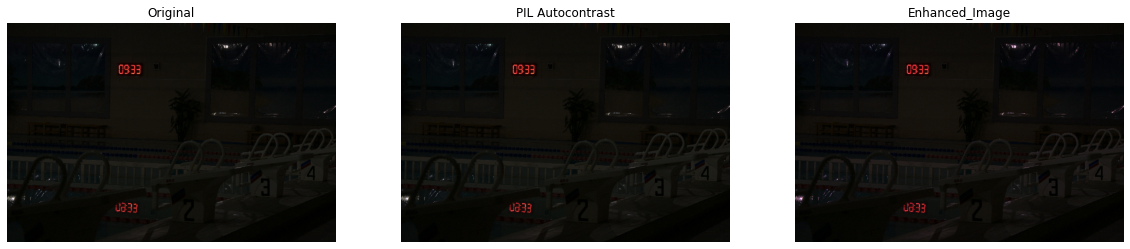

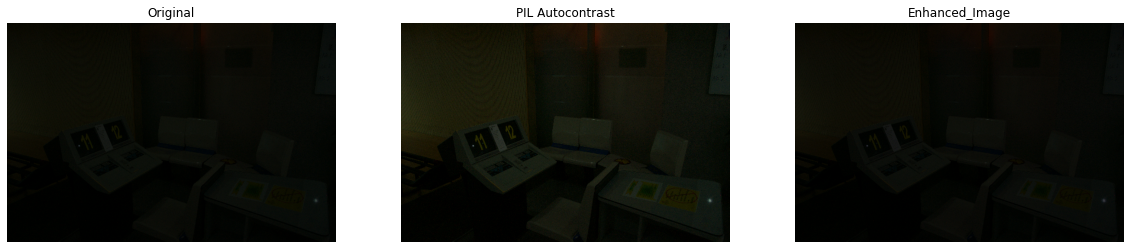

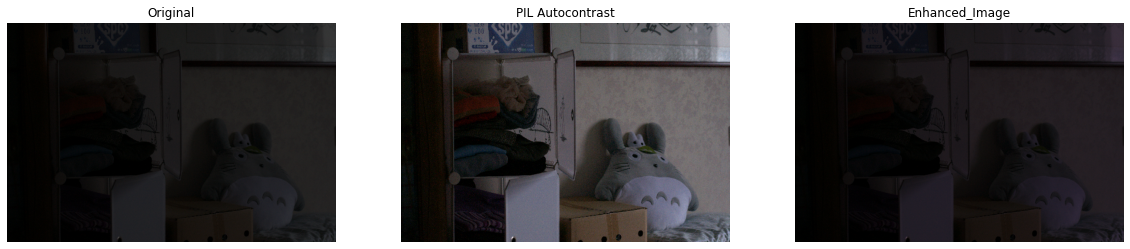

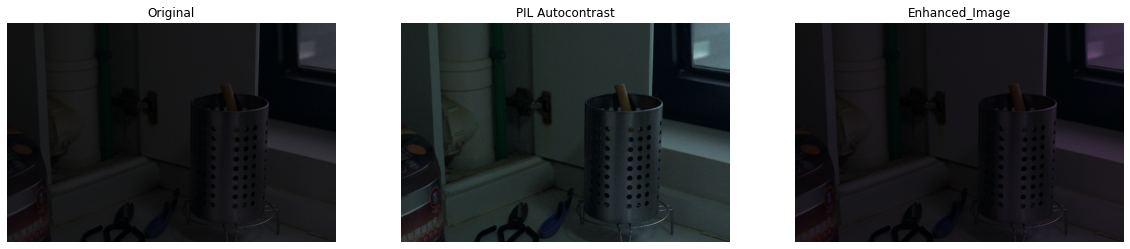

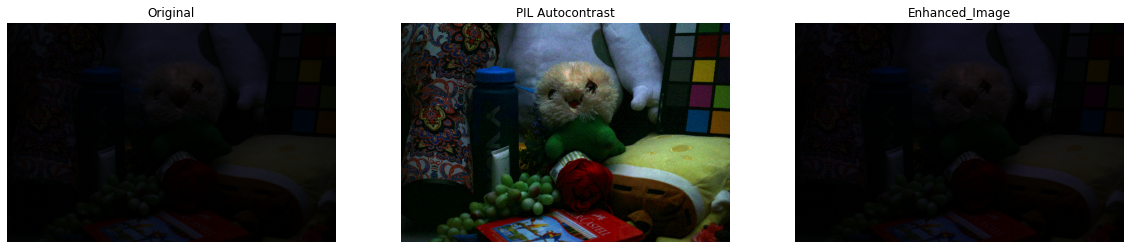

In [ ]:
for c,image_file in enumerate(test_image_files):
    if c==5:
      break
    original_image = Image.open(image_file)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced_Image"],
        (20, 12),
    )